In [59]:
import os
import shutil

# Define paths
source_base = "/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits"
dest_base = "/kaggle/working/fruit_dataset"

# Create destination folders
categories = ['Apple_Good', 'Apple_Bad', 'Banana_Good', 'Banana_Bad']
for category in categories:
    os.makedirs(os.path.join(dest_base, category), exist_ok=True)

# Move files
def copy_files(src_folder, dest_folder):
    for img in os.listdir(src_folder):
        shutil.copy(os.path.join(src_folder, img), os.path.join(dest_folder, img))

# Good Quality
copy_files(os.path.join(source_base, "Good Quality_Fruits", "Apple_Good"), os.path.join(dest_base, "Apple_Good"))
copy_files(os.path.join(source_base, "Good Quality_Fruits", "Banana_Good"), os.path.join(dest_base, "Banana_Good"))

# Bad Quality
copy_files(os.path.join(source_base, "Bad Quality_Fruits", "Apple_Bad"), os.path.join(dest_base, "Apple_Bad"))
copy_files(os.path.join(source_base, "Bad Quality_Fruits", "Banana_Bad"), os.path.join(dest_base, "Banana_Bad"))

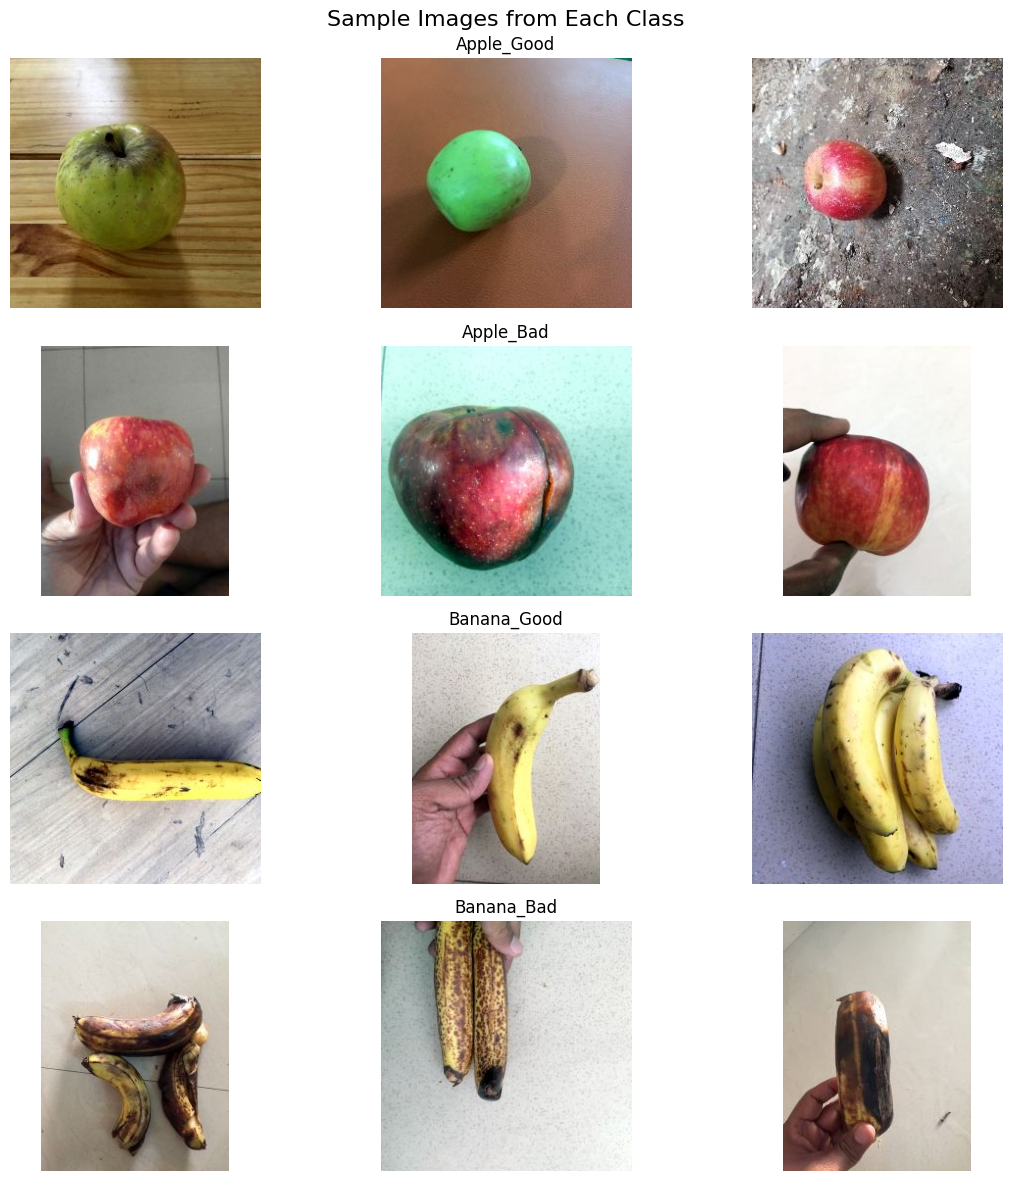

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


# Show 3 images from each category
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, category in enumerate(categories):
    class_path = os.path.join(dest_base, category)
    sample_imgs = random.sample(os.listdir(class_path), 3)
    
    for j in range(3):
        img_path = os.path.join(class_path, sample_imgs[j])
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 1:
            axes[i, j].set_title(category, fontsize=12)

plt.tight_layout()
plt.show()

In [61]:
for category in categories:
    class_dir = os.path.join(dest_base, category)
    num_images = len(os.listdir(class_dir))
    print(f"{category}: {num_images} images")


Apple_Good: 1149 images
Apple_Bad: 1141 images
Banana_Good: 1113 images
Banana_Bad: 1087 images


In [62]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
original_dataset_dir = '/kaggle/working/fruit_dataset'
output_dir = '/kaggle/working/fruit_dataset_split'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')

# Parameters
val_split = 0.2  # 20% validation

# Make output directories
for split_dir in [train_dir, val_dir]:
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Split each class separately
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    train_files, val_files = train_test_split(image_files, test_size=val_split, random_state=42, shuffle=True)

    # Copy train files
    for fname in train_files:
        src = os.path.join(class_dir, fname)
        dst = os.path.join(train_dir, class_name, fname)
        shutil.copyfile(src, dst)

    # Copy val files
    for fname in val_files:
        src = os.path.join(class_dir, fname)
        dst = os.path.join(val_dir, class_name, fname)
        shutil.copyfile(src, dst)

print("✅ Dataset split completed.")

✅ Dataset split completed.


In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Augmentation only for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# No augmentation for validation — just rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/fruit_dataset_split/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/fruit_dataset_split/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3590 images belonging to 4 classes.
Found 900 images belonging to 4 classes.


In [64]:
print(train_generator.class_indices)

{'Apple_Bad': 0, 'Apple_Good': 1, 'Banana_Bad': 2, 'Banana_Good': 3}


In [65]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Model architecture
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Model architecture
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D(pool_size=(2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,196 (500.77 KB)

 Trainable params: 127,748 (499.02 KB)

 Non-trainable params: 448 (1.75 KB)

In [66]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [67]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop,reduce_lr]
)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 383ms/step - accuracy: 0.6197 - loss: 1.2231 - val_accuracy: 0.2422 - val_loss: 2.5791 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.8154 - loss: 0.7605 - val_accuracy: 0.2933 - val_loss: 2.4504 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 353ms/step - accuracy: 0.8826 - loss: 0.6008 - val_accuracy: 0.4933 - val_loss: 2.3911 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 355ms/step - accuracy: 0.8759 - loss: 0.5895 - val_accuracy: 0.5511 - val_loss: 1.5669 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 356ms/step - accuracy: 0.8949 - loss: 0.5157 - val_accuracy: 0.7456 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 356ms/step - accuracy: 0.9106 - loss: 0.4485 - val_accuracy: 0.7611 - val_loss: 0.7834 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 357ms/step - accura

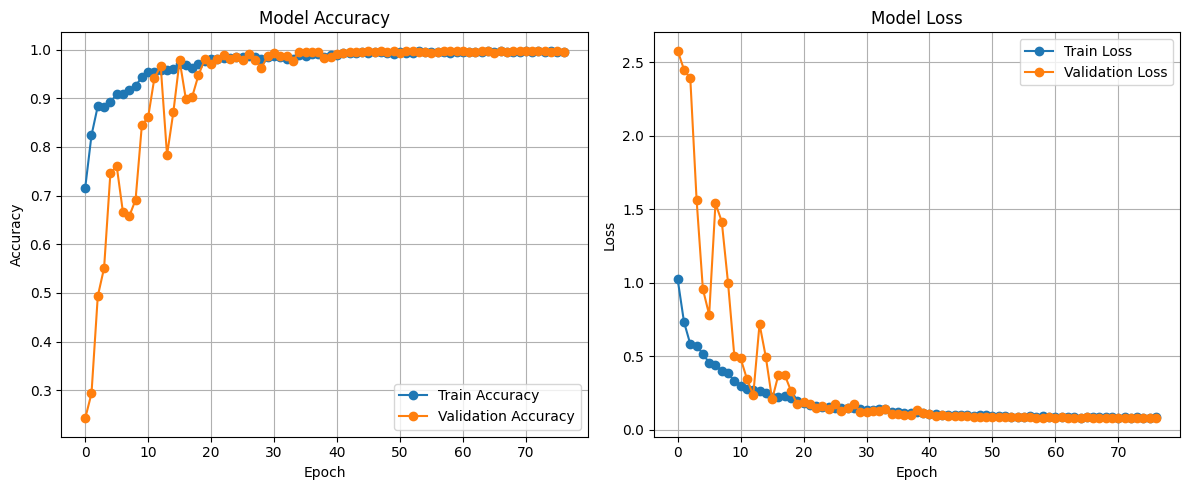

In [68]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


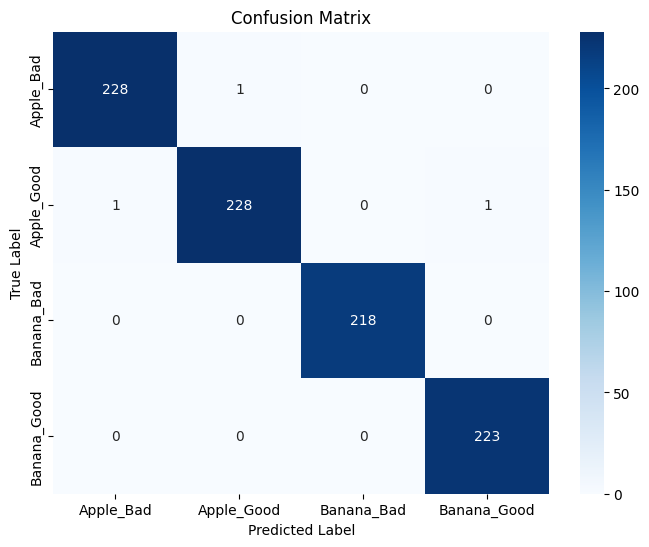

Classification Report:

              precision    recall  f1-score   support

   Apple_Bad       1.00      1.00      1.00       229
  Apple_Good       1.00      0.99      0.99       230
  Banana_Bad       1.00      1.00      1.00       218
 Banana_Good       1.00      1.00      1.00       223

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get predictions and true labels
val_generator.reset()
Y_true = val_generator.classes
Y_pred_probs = model.predict(val_generator, verbose=1)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Step 2: Get class labels
class_labels = list(val_generator.class_indices.keys())

# Step 3: Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Classification Report
report = classification_report(Y_true, Y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)


In [90]:
for layer in model.layers:
    print(layer.name)

conv2d_33
batch_normalization_29
max_pooling2d_33
conv2d_34
batch_normalization_30
max_pooling2d_34
conv2d_35
batch_normalization_31
max_pooling2d_35
global_average_pooling2d_12
dense_28
dropout_14
dense_29


In [97]:
!pip install shap

TensorFlow version: 2.18.0
Model summary:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,196 (500.77 KB)

 Trainable params: 127,748 (499.02 KB)

 Non-trainable params: 448 (1.75 KB)

Layer names: ['conv2d_33', 'batch_normalization_29', 'max_pooling2d_33', 'conv2d_34', 'batch_normalization_30', 'max_pooling2d_34', 'conv2d_35', 'batch_normalization_31', 'max_pooling2d_35', 'global_average_pooling2d_12', 'dense_28', 'dropout_14', 'dense_29']
Model compiled successfully.
Model built successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Dummy prediction output shape: (1, 4)
Model initialized successfully.
Image array shape: (1, 224, 224, 3) Min: 0.0 Max: 1.0
Found layer: conv2d_35
Image converted to tf.Tensor with shape: (1, 224, 224, 3)
Predicted class: Apple_Bad


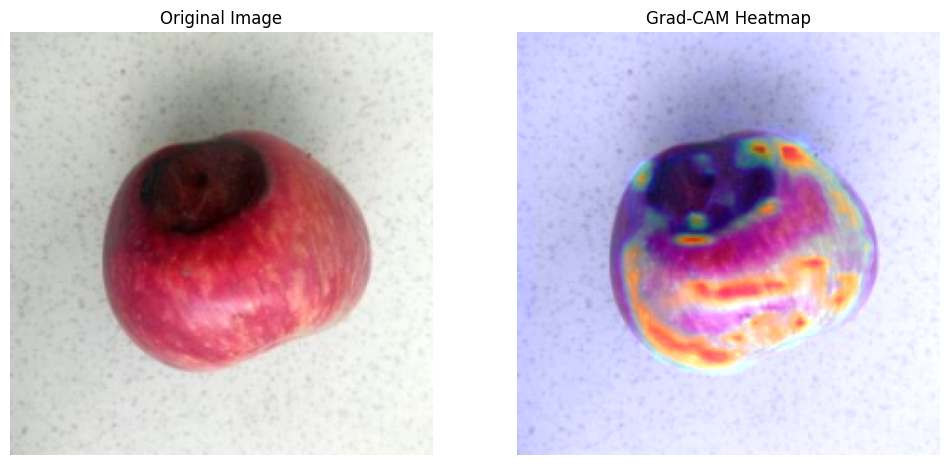

In [133]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to initialize model
def initialize_model(model, input_shape=(224, 224, 3)):
    try:
        # Explicitly build the model
        model.build((None, *input_shape))
        print("Model built successfully.")
        
        # Perform a dummy forward pass
        dummy_input = np.random.rand(1, *input_shape).astype(np.float32)
        output = model.predict(dummy_input)
        print("Dummy prediction output shape:", output.shape)  # Should be (1, 4)
        print("Model initialized successfully.")
    except Exception as e:
        print(f"Error during model initialization: {e}")
        raise e

# Function to get Grad-CAM heatmap (direct gradient approach)
def direct_gradcam_heatmap(model, img_array, last_conv_layer_name='conv2d_35', pred_index=None):
    try:
        # Verify layer exists
        conv_layer = model.get_layer(last_conv_layer_name)
        print(f"Found layer: {last_conv_layer_name}")
        
        # Convert img_array to tf.Tensor
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
        print("Image converted to tf.Tensor with shape:", img_tensor.shape)
        
        # Get layer index for conv2d_35
        layer_index = [layer.name for layer in model.layers].index(last_conv_layer_name)
        
        # Compute gradients
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            # Forward pass through the model
            x = img_tensor
            conv_outputs = None
            for i, layer in enumerate(model.layers):
                x = layer(x)
                if i == layer_index:
                    conv_outputs = x
            preds = x  # Final output is predictions
            
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        
        grads = tape.gradient(class_channel, conv_outputs)
        if grads is None:
            raise ValueError("Gradients are None. Check model connectivity.")
        
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
        return heatmap.numpy(), pred_index
    except Exception as e:
        print(f"Error in direct Grad-CAM: {e}")
        raise e

# Function to display and save original image and Grad-CAM heatmap
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image at {img_path}")
    img = cv2.resize(img, (224, 224))
    
    # Create Grad-CAM heatmap
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    # Display both images
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # Grad-CAM heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    
    # Save both images
    plt.savefig('gradcam_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
try:
    # Print TensorFlow version
    print(f"TensorFlow version: {tf.__version__}")

    # Print model summary and layer names
    print("Model summary:")
    model.summary()
    print("Layer names:", [layer.name for layer in model.layers])

    # Ensure model is compiled
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Model compiled successfully.")

    # Initialize model
    initialize_model(model)

    # Load and preprocess image
    img_path = '/kaggle/working/fruit_dataset_split/val/Apple_Bad/IMG_20190910_172145_2.jpg'  # Replace with a valid image path
    img_array = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img_array)
    img_array = img_array / 255.0  # Rescale as per your preprocessing
    img_array = np.expand_dims(img_array, axis=0)
    print("Image array shape:", img_array.shape, "Min:", img_array.min(), "Max:", img_array.max())

    # Generate Grad-CAM heatmap
    heatmap, pred_index = direct_gradcam_heatmap(model, img_array, last_conv_layer_name='conv2d_35')
    class_names = list(train_generator.class_indices.keys())  # e.g., ['Bad_Apple', 'Bad_Banana', 'Good_Apple', 'Good_Banana']
    print(f"Predicted class: {class_names[pred_index]}")
    display_gradcam(img_path, heatmap)

except Exception as e:
    print(f"Error during Grad-CAM: {e}")

In [135]:
import tensorflow as tf
model = tf.keras.models.load_model('model.h5')